In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

import gym
from gym_utils_q_learning import AtariEnv
from gym_utils_q_learning import AtariFrame
from AtariACModels import AtariActorModel, AtariCriticModel
import numpy as np
import random

#environment_name = "SpaceInvaders-v4"
environment_name  = "SpaceInvadersNoFrameskip-v4"

# environment_name = "Pong-v4"
# typical_bad_game_frame_count = 1100
# reward_frame_shift = -1

action_count = gym.make(environment_name).action_space.n

In [2]:
#play a quick game to test out gym_utils

if False:
    atari_env = AtariEnv(environment_name)
    model = AtariActorModel(action_count).cuda()
    action = atari_env.env.action_space.sample()

    for i in range(4000):
        atari_frame = atari_env.step(action)
        if atari_frame is None:
            break
        processed_frames = atari_frame.get_next_processed_frames()
        #print("processed_frames.shape: {}".format(processed_frames.shape))
        processed_frames = np.reshape(processed_frames, (1,)+processed_frames.shape)
        #print("processed_frames.shape: {}".format(processed_frames.shape))
        img_tensor = torch.from_numpy(processed_frames).float().cuda()

        output = model(img_tensor)
        action_array = output.detach().cpu().numpy()[0]
        print("model_actions: {}".format(action_array))
        action = np.argmax(action_array)

    atari_env.close()
    
    print("len(atari_env.frame_buffer): {}".format(len(atari_env.frame_buffer)))
    atariFrame = atari_env.frame_buffer[107]
    processed_frames = atariFrame.get_processed_frames()
    print("processed_frames.shape: {}".format(processed_frames.shape))
    print("sample_frame.frame_index: {}".format(atariFrame.frame_index))
    print("sample_frame.reward_list: {}".format(atariFrame.reward_list))
    atariFrame.show_processed_frame()

In [3]:
#play a game. feed each frame into the model and see what we get
def play_game(atari_env, model, epsilon, max_frames=5000):
    current_action = 0
    done = False
    frame_counter = 0
    action_count = atari_env.env.action_space.n
    choices = np.arange(action_count)
    
    while not done:
        save_step = frame_counter >= 60
        atari_frame = atari_env.step(current_action, save_step=save_step)

        if atari_frame is None:  #processed_frames == None
            done = True
            continue
            
        processed_frames = atari_frame.get_processed_frames()

        processed_frames_batch = np.reshape(processed_frames, (1,)+processed_frames.shape)
        img_tensor = torch.from_numpy(processed_frames_batch).float().cuda()
        output = model(img_tensor)
        action_array = output.detach().cpu().numpy()[0]
        # print("play_game action_array: {}".format(action_array))
    
        rand = random.uniform(0, 1)
        if rand < epsilon:
            current_action = atari_env.env.action_space.sample()
        else:
            #current_action = np.argmax(action_array)
            current_action = np.random.choice(choices, p=action_array)

        frame_counter += 1
        if frame_counter > max_frames:
            break

def game_step(atari_env, model, epsilon, max_frames=5000):
    current_action = 0
    done = False
    
    frame = atari_env.frame_buffer[-1]
    processed_frames = frame.get_next_processed_frames()

    processed_frames_batch = np.reshape(processed_frames, (1,)+processed_frames.shape)
    img_tensor = torch.from_numpy(processed_frames_batch).float().cuda()
    output = model(img_tensor)
    action_array = output.detach().cpu().numpy()[0]

    rand = random.uniform(0, 1)
    if rand < epsilon:
        current_action = atari_env.env.action_space.sample()
    else:
        current_action = np.argmax(action_array)

    atari_frame = atari_env.step(current_action, save_step=save_step)

    if atari_frame is None:
        return True
    
    return False

            
def get_train_batch(atari_env, batch_size):
    rand_arr = np.arange(len(atari_env.frame_buffer)-1)
    np.random.shuffle(rand_arr)
   
    index_counter = 0
    batch_index_counter = 0
    
    frame_batch        = np.zeros((batch_size, 4, 210, 160))
    next_frame_batch   = np.zeros((batch_size, 4, 210, 160))
    reward_batch       = np.zeros(batch_size)
    actions_batch      = np.zeros(batch_size)
    next_actions_batch = np.zeros(batch_size)
    frame_number_batch = np.zeros(batch_size)
    
    for batch_index in range(batch_size):
        frame_number = rand_arr[batch_index]
        atari_frame = atari_env.frame_buffer[frame_number]
        next_atari_frame = atari_env.frame_buffer[frame_number+1]
        
        frame_batch[batch_index]      = atari_frame.get_processed_frames()
        next_frame_batch[batch_index] = atari_frame.get_next_processed_frames()
        reward_batch[batch_index]     = atari_frame.getReward()
        actions_batch[batch_index]    = atari_frame.action_taken
        next_actions_batch[batch_index] = next_atari_frame.action_taken
        frame_number_batch[batch_index] = frame_number

    return frame_batch, next_frame_batch, actions_batch, next_actions_batch, reward_batch, frame_number_batch
    
def action_batch_to_one_hot(action_count, action_batch):
#     print(action_batch.shape)
#     print(action_batch)
    return_value = np.zeros((action_batch.shape[0], action_count))
    for i in range(action_batch.shape[0]):
        this_row = np.zeros(action_count)
#         print("action_batch[i][0]: {}".format(action_batch[i][0]))
        this_row[int(action_batch[i][0])] = 1.0
        return_value[i] = this_row
    return return_value
    
    

def soft_update(local_model, target_model, tau):
    """Soft update model parameters.
    θ_target = τ*θ_local + (1 - τ)*θ_target
    Params
    ======
        local_model (PyTorch model): weights will be copied from
        target_model (PyTorch model): weights will be copied to
        tau (float): interpolation parameter 
    """
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
        target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [4]:
actor_model_local  = AtariActorModel(action_count).cuda()
actor_model_target = AtariActorModel(action_count).cuda()

critic_model_local  = AtariCriticModel(action_count).cuda()
critic_model_target = AtariCriticModel(action_count).cuda()

# atari_model_local.load_state_dict(torch.load("space_invaders.pt"));
# atari_model_target_1.load_state_dict(torch.load("space_invaders.pt"));
# atari_model_target_2.load_state_dict(torch.load("space_invaders.pt"));

atari_env_train = AtariEnv(environment_name)



In [8]:
learning_rate_actor = .0005 #.000005
learning_rate_critic = .005 #.000005
actor_optimizer = optim.Adam(actor_model_local.parameters(), lr=learning_rate_actor)
critic_optimizer = optim.Adam(critic_model_local.parameters(), lr=learning_rate_critic)

epochs = 100
gamma = .99
TAU = .005 #1e-3  

epsilon_max = 0.95
epsilon_min = 0.15
epsilon_decay_frames = 50000
trainings_per_epoch = 100
batch_size = 128

for epoch in range(epochs):
    total_critic_loss = 0
    total_actor_loss = 0
    
    #play a game. game info is saved to the AtariEnv object
    atari_env_train.reset()     
    epsilon = epsilon_max - (epsilon_max-epsilon_min)*(atari_env_train.global_step_counter/epsilon_decay_frames)
    epsilon = max(epsilon_min, epsilon)
    actor_model_local.eval()
    play_game(atari_env_train, actor_model_local, epsilon)  
    actor_model_local.train()
    
    for training_iter in range(trainings_per_epoch):
        
        # TODO - instead of palying a whole game, move forward one step and train a batch.
        
        if atari_env_train.global_step_counter < 8000:
            continue
        
        frame_batch, next_frame_batch, actions_batch, next_actions_batch, reward_batch, frame_number_batch = get_train_batch(atari_env_train, batch_size)

        # print(frame_batch.shape)
        # print(next_frame_batch.shape)
        # print(actions_batch)
        # print(reward_batch)
        # print(frame_number_batch)

        # convert to tensors for input into the models.
        reward_batch_reshaped = np.reshape(reward_batch, (batch_size, 1))   #unsqueeze?
        reward_batch_tensor = torch.from_numpy(reward_batch_reshaped).float().cuda()
        img_tensor = torch.from_numpy(frame_batch).float().cuda()
        img_tensor_next = torch.from_numpy(next_frame_batch).float().cuda()
        actions_batch_reshaped = np.reshape(actions_batch, (batch_size, 1))
        actions_batch_reshaped = action_batch_to_one_hot(action_count, actions_batch_reshaped)
        actions_batch_tensor = torch.from_numpy(actions_batch_reshaped).float().cuda()
        #print("actions_batch_tensor: {}".format(actions_batch_tensor))
        next_actions_batch_reshaped = np.reshape(next_actions_batch, (batch_size, 1))
        next_actions_batch_reshaped = action_batch_to_one_hot(action_count, next_actions_batch_reshaped)
        next_actions_batch_tensor = torch.from_numpy(next_actions_batch_reshaped).float().cuda()
        #print("next_actions_batch_tensor: {}".format(next_actions_batch_tensor))
        
        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models

        # Compute Q targets for current states (y_i)
        Q_targets_next = critic_model_target(img_tensor_next, next_actions_batch_tensor)
        Q_targets = reward_batch_tensor + (gamma * Q_targets_next)
            
        # Compute critic loss
        Q_expected = critic_model_local(img_tensor, actions_batch_tensor)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
            
        # Minimize the critic loss
        critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(critic_model_local.parameters(), 1)
        critic_optimizer.step()
        total_critic_loss += critic_loss.item()
            
        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = actor_model_local(img_tensor)
        actor_loss = -critic_model_local(img_tensor, actions_pred).mean()
            
        # Minimize the actor loss
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()
        total_actor_loss += actor_loss.item()
            
        # ----------------------- update target networks ----------------------- #
        #use very small Tau and update with every step
        soft_update(critic_model_local, critic_model_target, TAU)
        soft_update(actor_model_local, actor_model_target, TAU)

    print("epoch: {}, score: {}, epsilon: {:.3f}, frames ran: {}, critic loss: {:.6f}, actor_loss: {:.6f}".format(epoch, atari_env_train.current_score, epsilon, atari_env_train.global_step_counter, total_critic_loss/trainings_per_epoch, total_actor_loss/trainings_per_epoch))
    
atari_env_train.close()

epoch: 0, score: 24.0, epsilon: 0.150, frames ran: 464056, critic loss: 0.093633, actor_loss: -0.640677
epoch: 1, score: 4.0, epsilon: 0.150, frames ran: 465400, critic loss: 0.115362, actor_loss: -0.637655
epoch: 2, score: 8.0, epsilon: 0.150, frames ran: 466972, critic loss: 0.096921, actor_loss: -0.639078
epoch: 3, score: 11.0, epsilon: 0.150, frames ran: 468960, critic loss: 0.117639, actor_loss: -0.646034
epoch: 4, score: 15.0, epsilon: 0.150, frames ran: 472212, critic loss: 0.099931, actor_loss: -0.645035
epoch: 5, score: 10.0, epsilon: 0.150, frames ran: 473976, critic loss: 0.130410, actor_loss: -0.641016
epoch: 6, score: 5.0, epsilon: 0.150, frames ran: 475196, critic loss: 0.111096, actor_loss: -0.637024
epoch: 7, score: 18.0, epsilon: 0.150, frames ran: 478556, critic loss: 0.095147, actor_loss: -0.639879
epoch: 8, score: 10.0, epsilon: 0.150, frames ran: 480492, critic loss: 0.097078, actor_loss: -0.640775
epoch: 9, score: 6.0, epsilon: 0.150, frames ran: 482224, critic lo

epoch: 79, score: 7.0, epsilon: 0.150, frames ran: 635432, critic loss: 0.077119, actor_loss: -0.837880
epoch: 80, score: 17.0, epsilon: 0.150, frames ran: 637760, critic loss: 0.063064, actor_loss: -0.846788
epoch: 81, score: 12.0, epsilon: 0.150, frames ran: 639672, critic loss: 0.080593, actor_loss: -0.844028
epoch: 82, score: 8.0, epsilon: 0.150, frames ran: 641256, critic loss: 0.082849, actor_loss: -0.851453
epoch: 83, score: 15.0, epsilon: 0.150, frames ran: 643508, critic loss: 0.075975, actor_loss: -0.852576
epoch: 84, score: 6.0, epsilon: 0.150, frames ran: 644568, critic loss: 0.084709, actor_loss: -0.861877
epoch: 85, score: 7.0, epsilon: 0.150, frames ran: 645636, critic loss: 0.081526, actor_loss: -0.866398
epoch: 86, score: 13.0, epsilon: 0.150, frames ran: 648432, critic loss: 0.081310, actor_loss: -0.865486
epoch: 87, score: 7.0, epsilon: 0.150, frames ran: 649980, critic loss: 0.067473, actor_loss: -0.871347
epoch: 88, score: 4.0, epsilon: 0.150, frames ran: 651088, c

In [7]:
torch.save(actor_model_local.state_dict(), "space_invaders_actor_local.pt")
torch.save(actor_model_target.state_dict(), "space_invaders_actor_target.pt")
torch.save(critic_model_local.state_dict(), "space_invaders_critic_local.pt")
torch.save(critic_model_target.state_dict(), "space_invaders_critic_target.pt")


In [18]:
#play a game using the model
atari_env_play = AtariEnv(environment_name)
atari_env_play.reset()
#play_game(atari_env_play, atari_model_local, 0.05, max_frames=2000)
play_game(atari_env_play, actor_model_local, 0.1)
#print("score: {}".format(atari_env_play.current_score))
atari_env_play.close()

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])

action: 0.0
reward: 0.0
frame:  862.0


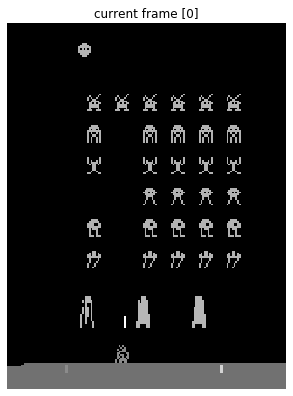

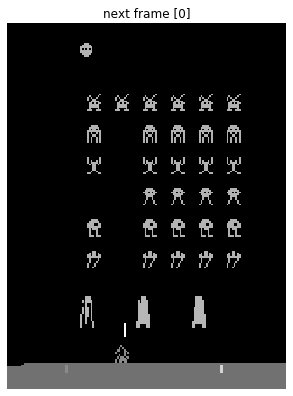

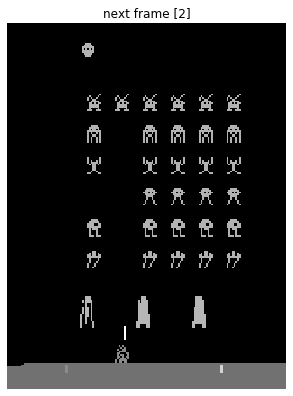

In [95]:
#get some information from  the batch to make sure it looks good.

import matplotlib.pyplot as plt

frame_batch, next_frame_batch, actions_batch, reward_batch, frame_number_batch = get_train_batch(atari_env_train, batch_size)

print("action: {}".format(actions_batch[0]))
print("reward: {}".format(reward_batch[0]))
print("frame:  {}".format(frame_number_batch[0]))

plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("current frame [0]")
plt.imshow(frame_batch[0][0], cmap="gray")
plt.axis("off")
plt.show()

# plt.figure(figsize=(11, 7))
# plt.subplot(121)
# plt.title("current frame [2]")
# plt.imshow(frame_batch[0][2], cmap="gray")
# plt.axis("off")
# plt.show()

plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("next frame [0]")
plt.imshow(next_frame_batch[0][0], cmap="gray")
plt.axis("off")
plt.show()

# plt.figure(figsize=(11, 7))
# plt.subplot(121)
# plt.title("next frame [2]")
# plt.imshow(next_frame_batch[0][2], cmap="gray")
# plt.axis("off")
# plt.show()